In [1]:
# !conda install pytorch torchvision cuda90 -c pytorch -y
# ! pip install qn

In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

def cuda(tensor):
    return tensor.cuda() if torch.cuda.is_available() else tensor

def cpu(tensor):
    return tensor.cpu() if torch.cuda.is_available() else tensor


prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = cuda(DisNet(config['dim_x']))
gen_net = cuda(GenNet(config['dim_z'],config['dim_x']))

dis_optim = optim.Adam(dis_net.parameters(), lr=config['dis_lr'],
    betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.Adam(gen_net.parameters(), lr=config['gen_lr'],
    betas=(config['gen_beta1'],config['gen_beta2']))


500 82.6984715461731


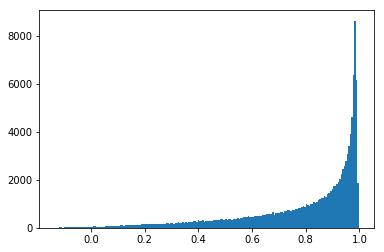

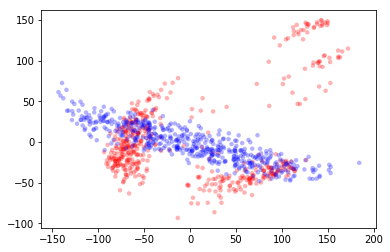

1000 81.4959990978241


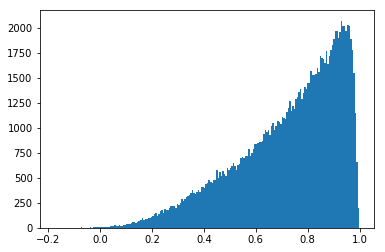

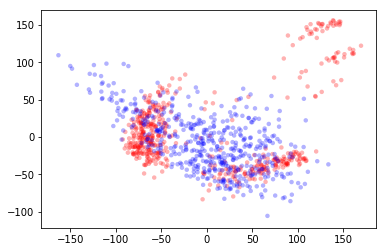

1500 81.08047819137573


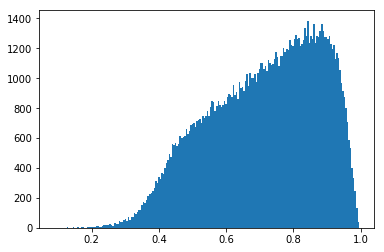

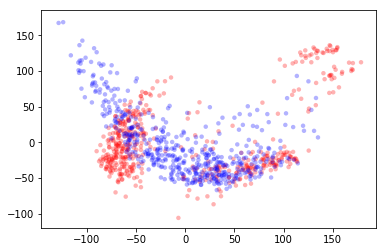

2000 80.8410918712616


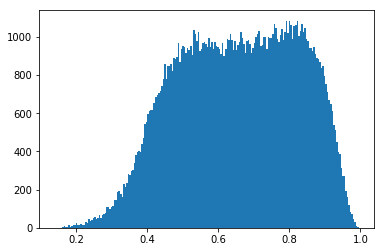

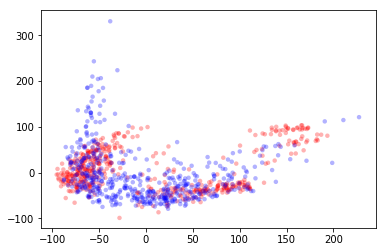

2500 80.74048662185669


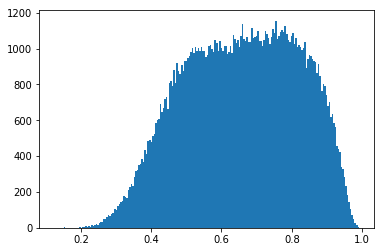

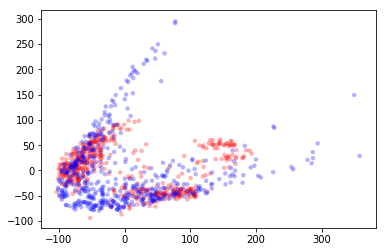

3000 80.72230005264282


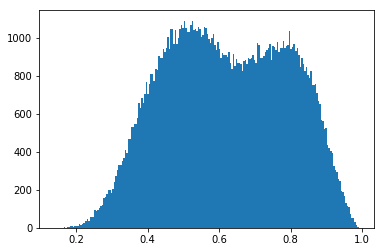

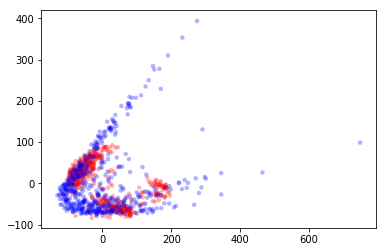

3500 80.73475337028503


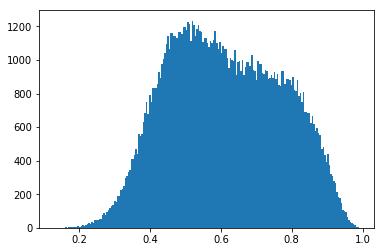

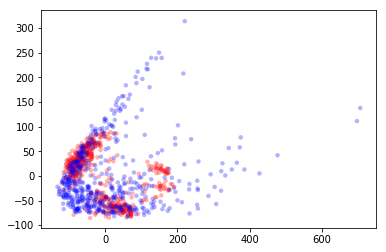

4000 80.91609692573547


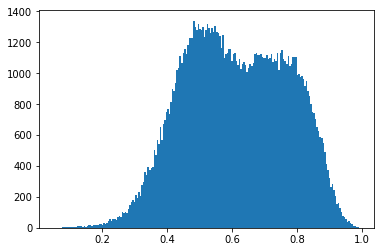

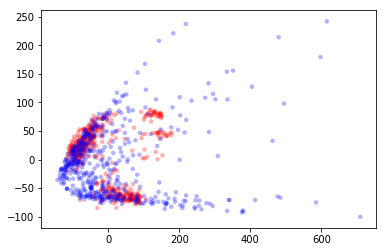

4500 80.74677920341492


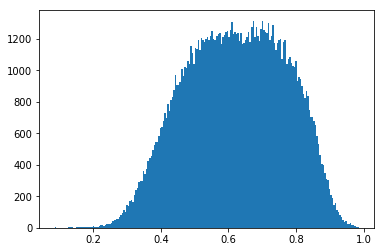

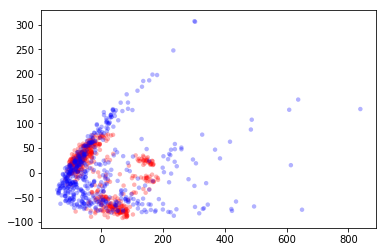

5000 81.77062749862671


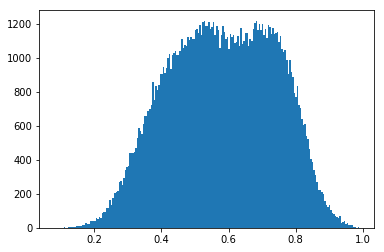

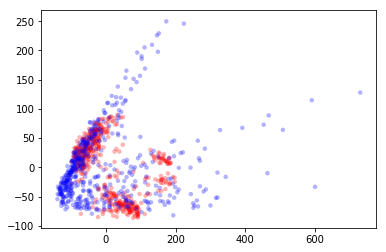

5500 81.57862424850464


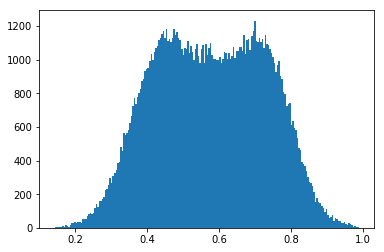

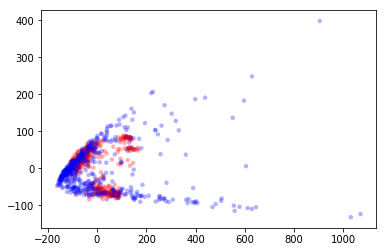

6000 81.13866686820984


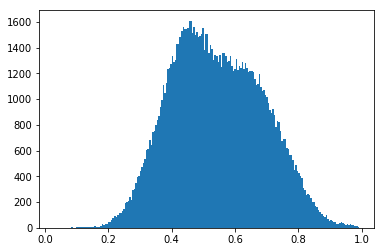

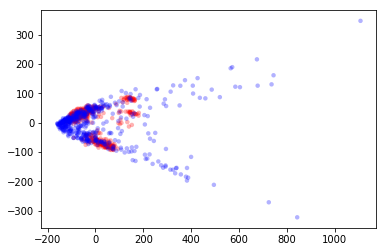

6500 80.95895957946777


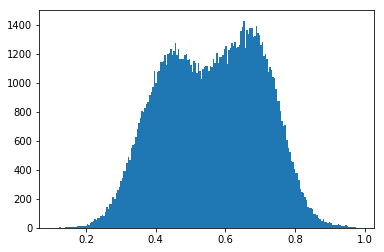

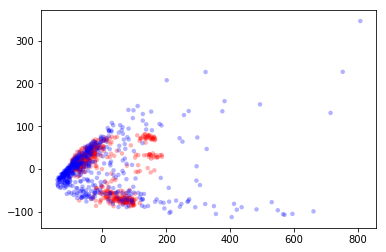

7000 81.20369911193848


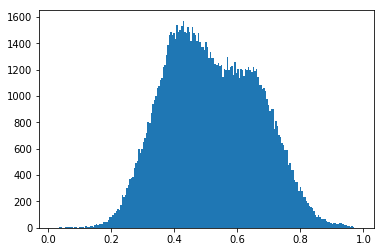

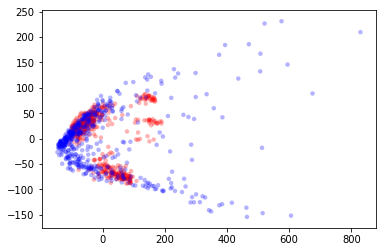

7500 80.83760857582092


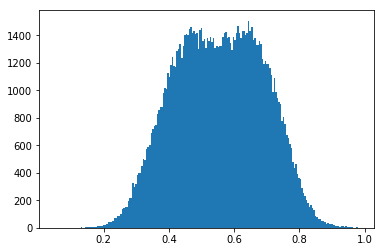

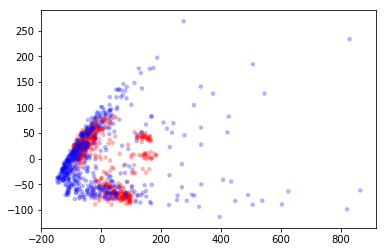

8000 81.16654181480408


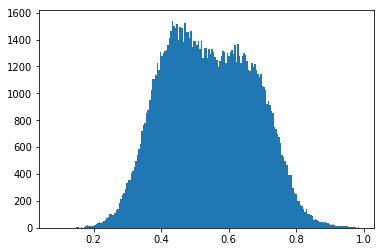

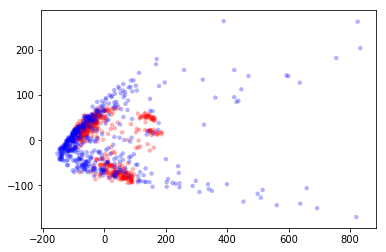

8500 82.78662037849426


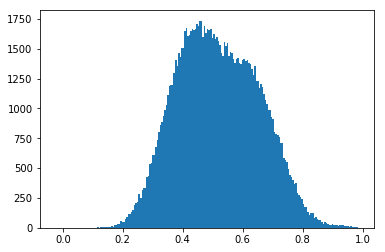

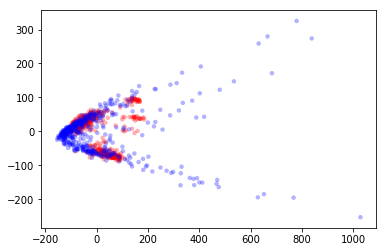

9000 81.30670142173767


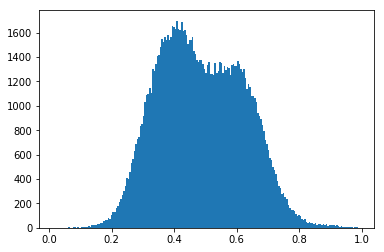

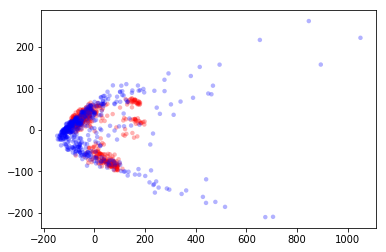

9500 81.34770560264587


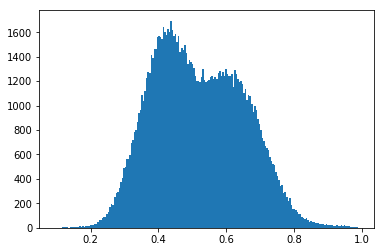

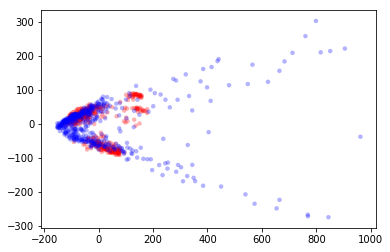

10000 81.35092258453369


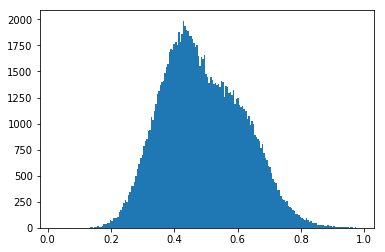

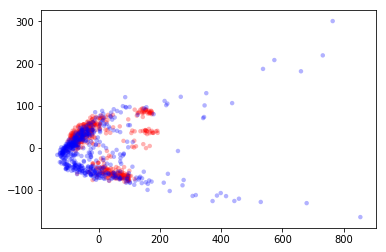

10500 81.4705798625946


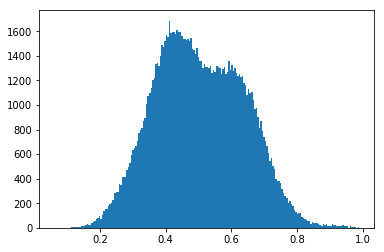

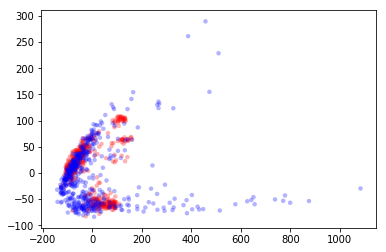

11000 81.33833026885986


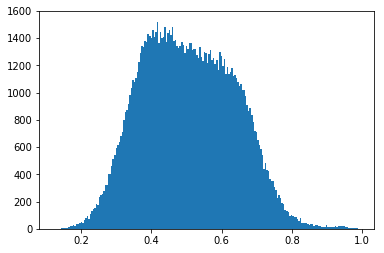

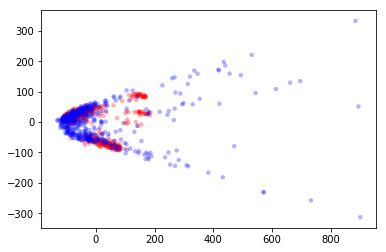

11500 81.40125370025635


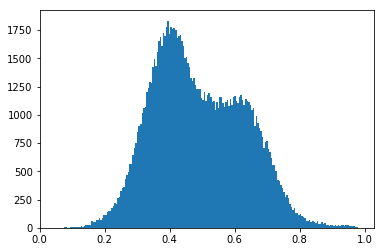

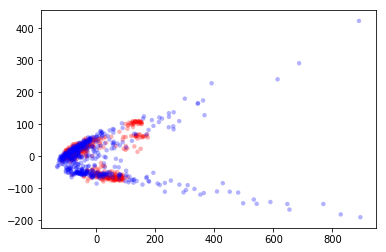

12000 81.50143337249756


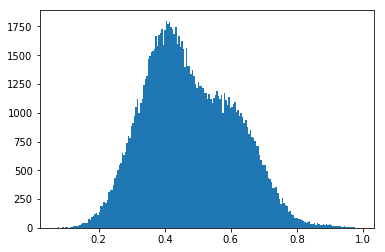

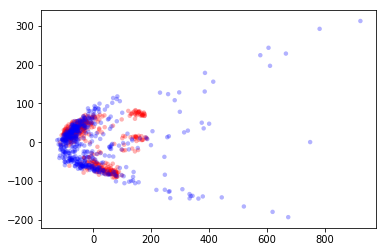

12500 81.48543334007263


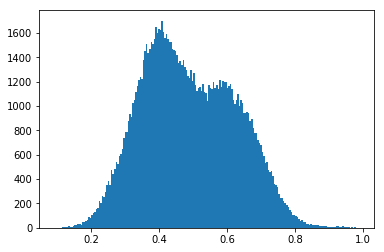

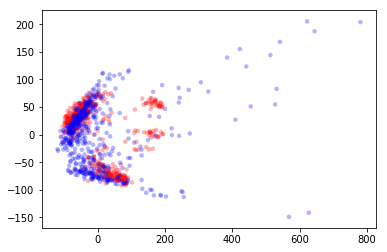

13000 81.18940615653992


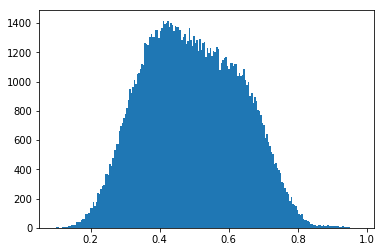

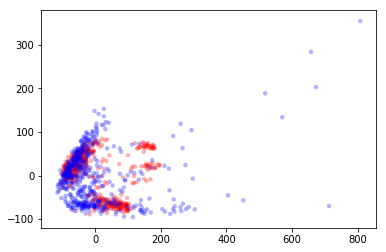

13500 81.03059339523315


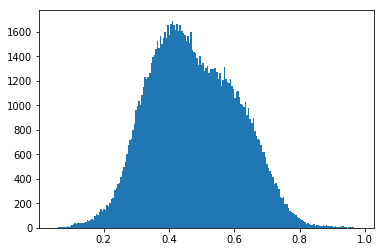

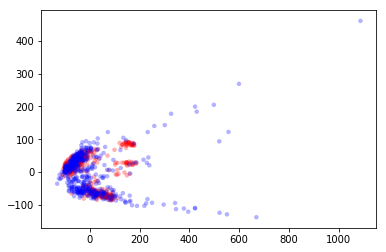

14000 81.36228132247925


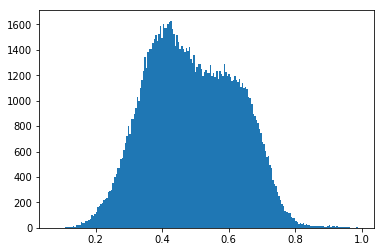

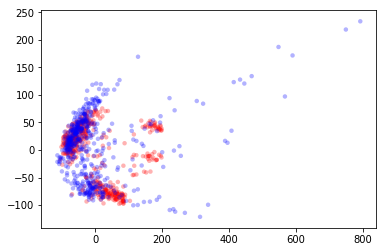

14500 81.77356147766113


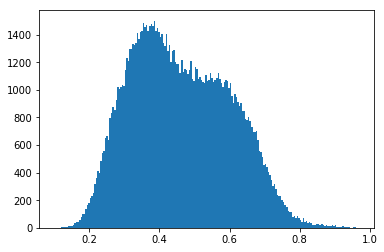

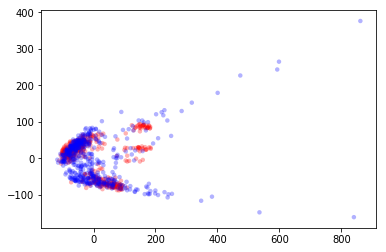

15000 80.96557831764221


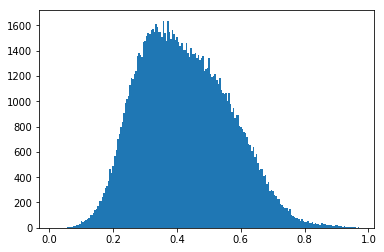

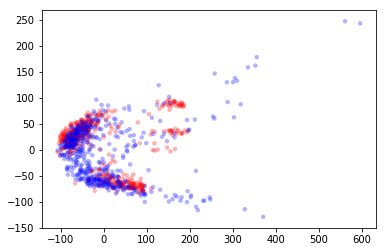

15500 81.16265821456909


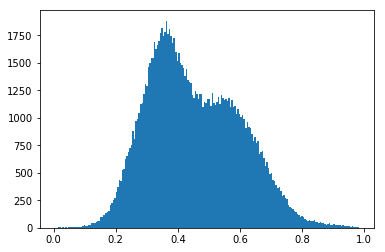

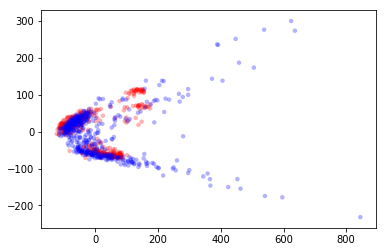

16000 81.08675575256348


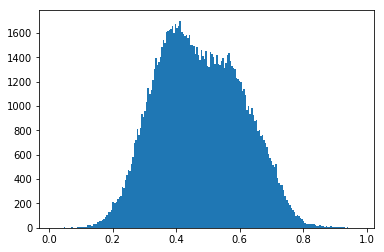

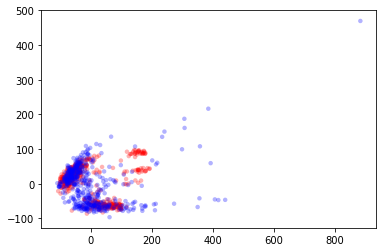

16500 81.28136396408081


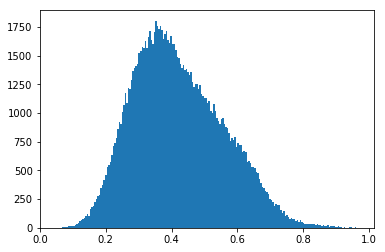

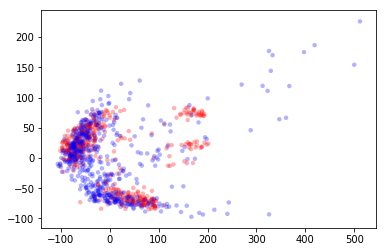

17000 81.14981627464294


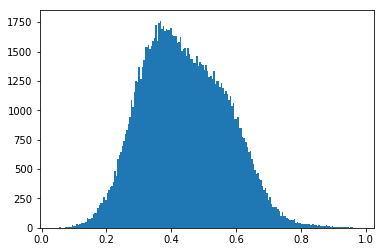

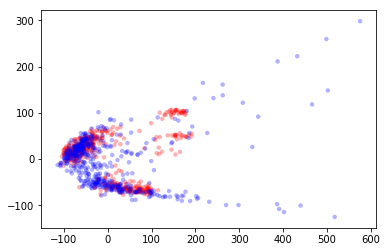

17500 81.2357530593872


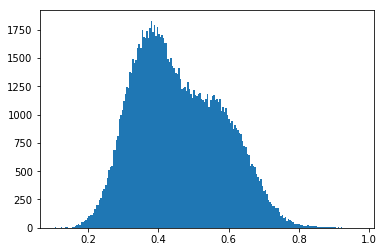

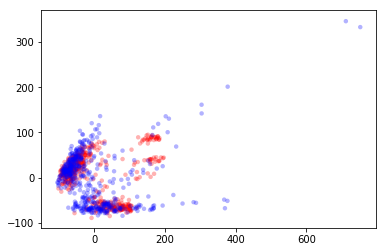

18000 81.59581708908081


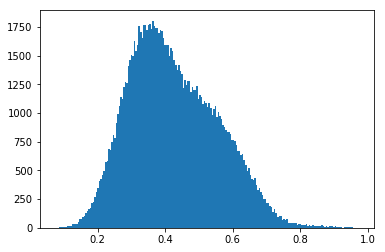

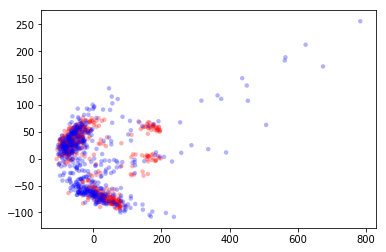

18500 81.16898131370544


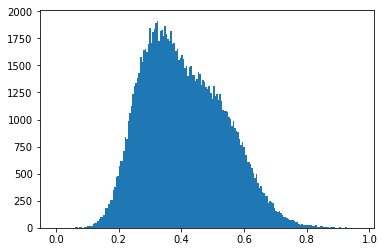

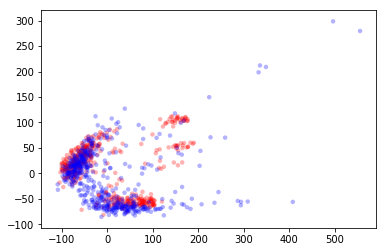

19000 81.42477107048035


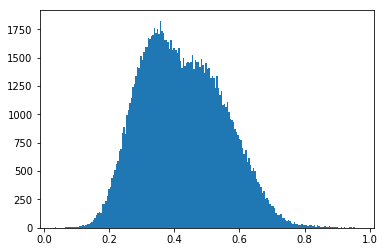

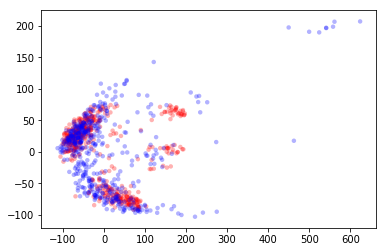

19500 81.39408254623413


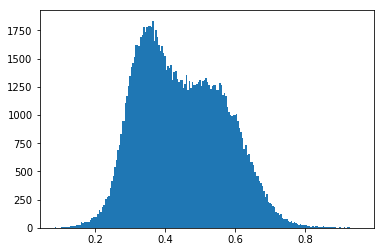

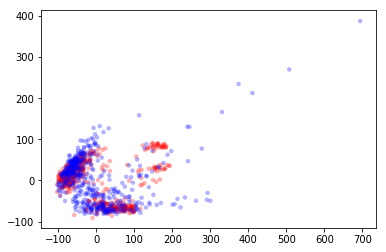

20000 82.06450343132019


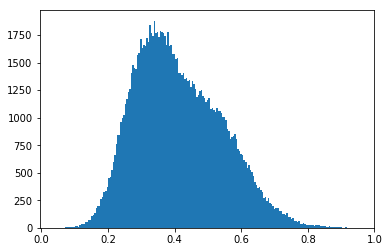

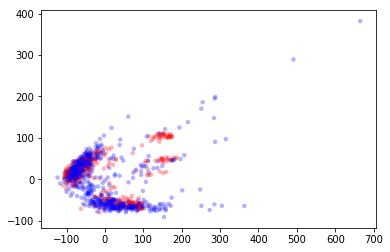

20500 81.35685777664185


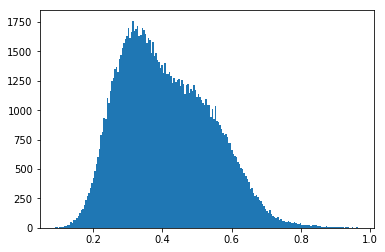

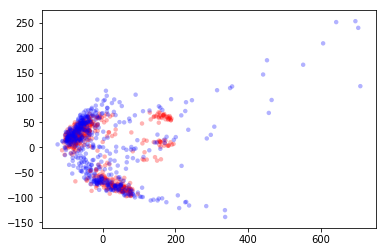

21000 82.31134033203125


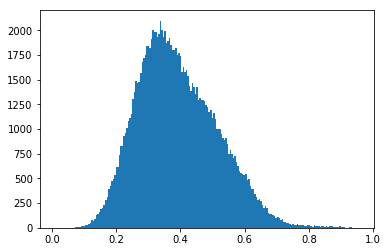

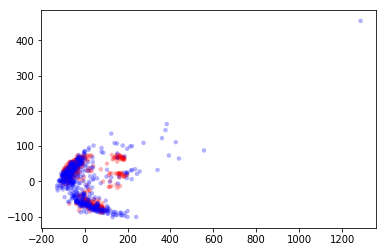

21500 82.58000445365906


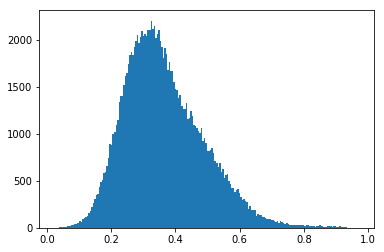

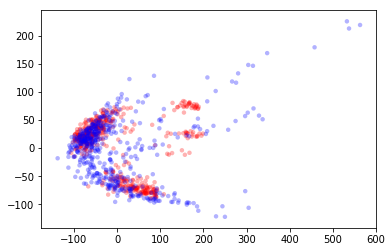

22000 81.53454256057739


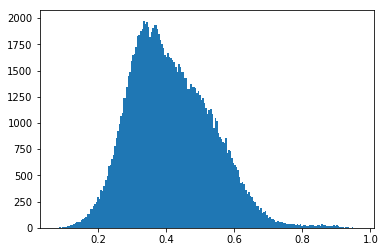

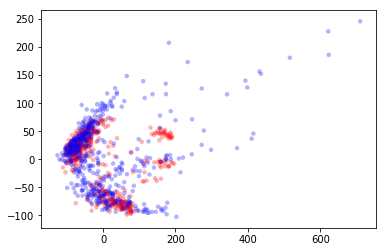

22500 81.27646017074585


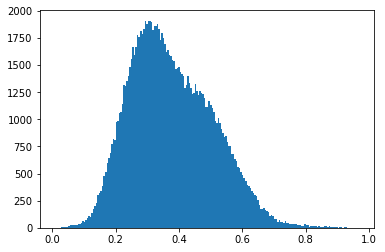

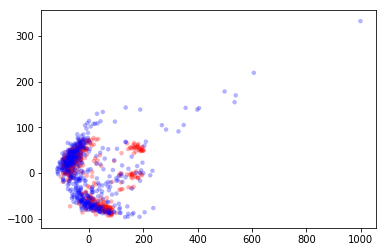

23000 81.52633905410767


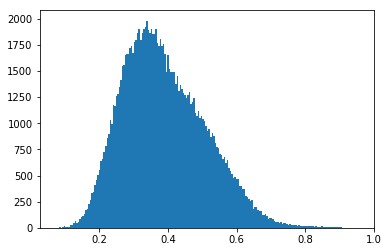

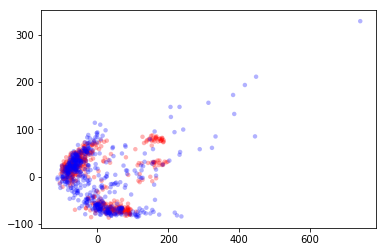

23500 81.21013450622559


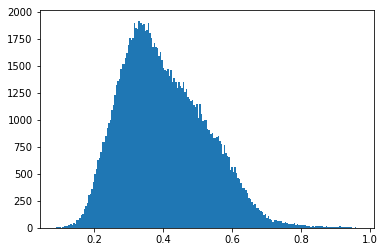

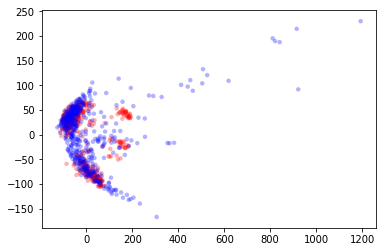

24000 81.08572363853455


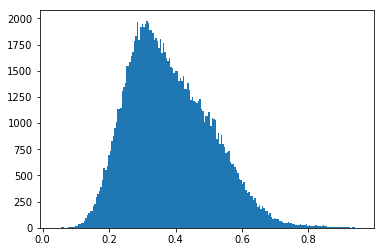

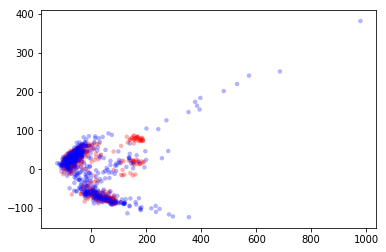

24500 81.37103223800659


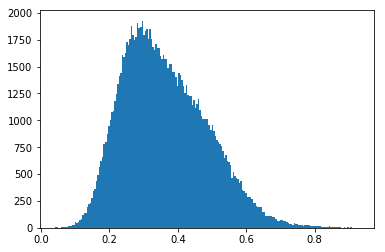

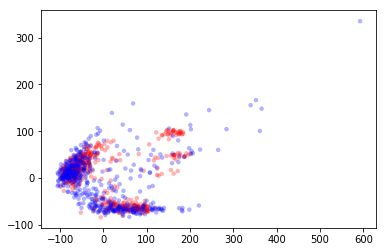

25000 81.24597072601318


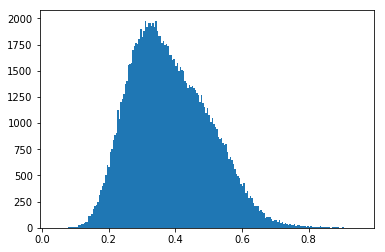

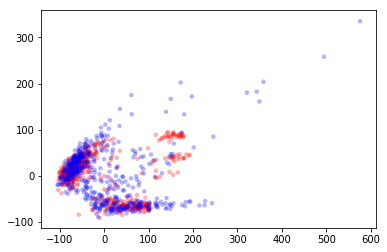

25500 81.33987402915955


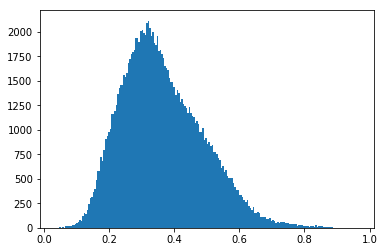

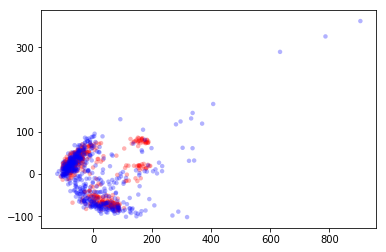

26000 81.20725393295288


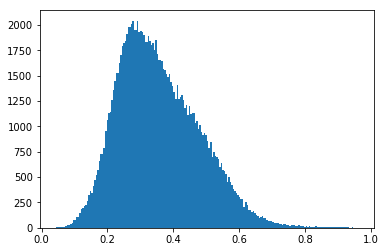

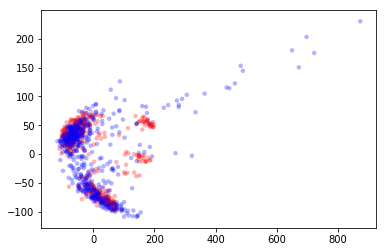

26500 81.52689528465271


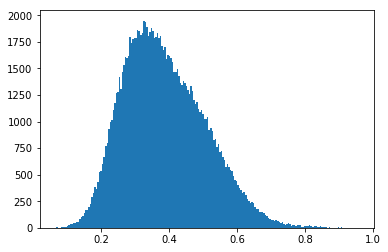

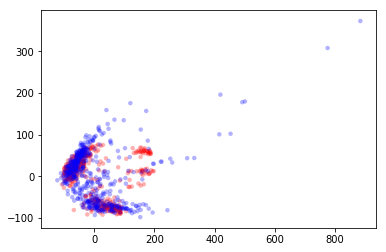

27000 81.55121207237244


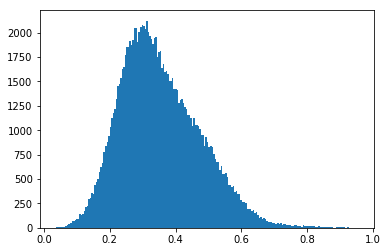

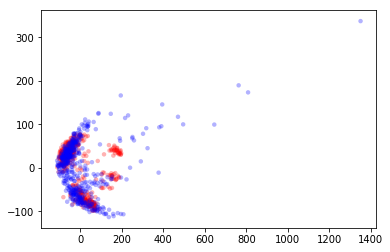

27500 81.42566657066345


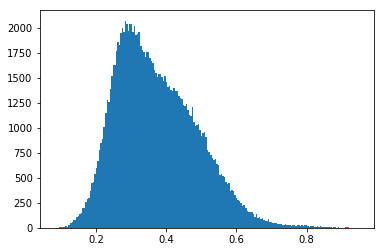

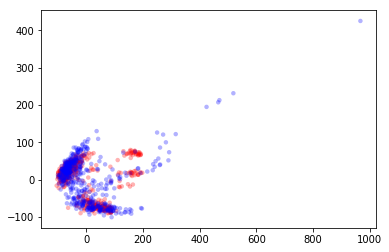

28000 81.6657543182373


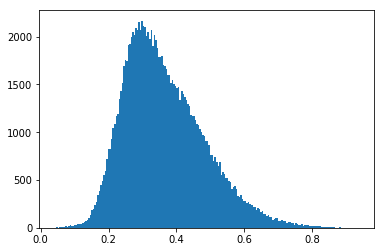

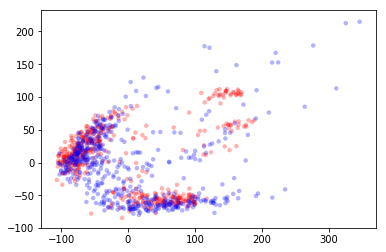

28500 81.58115339279175


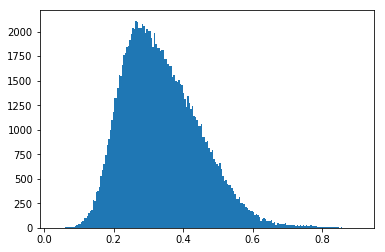

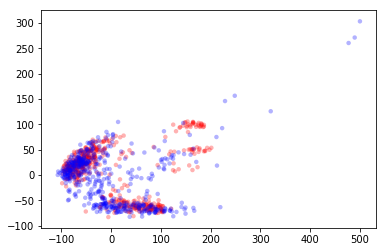

29000 80.99202871322632


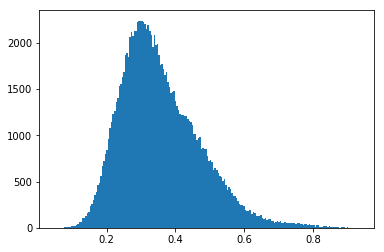

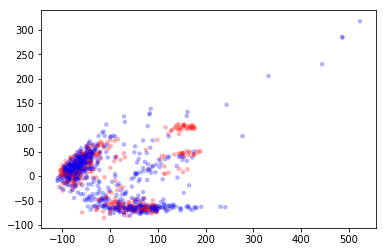

29500 81.86998653411865


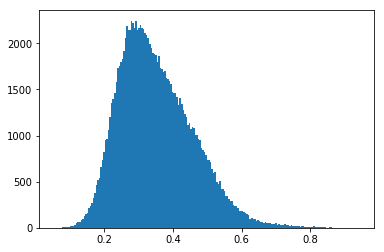

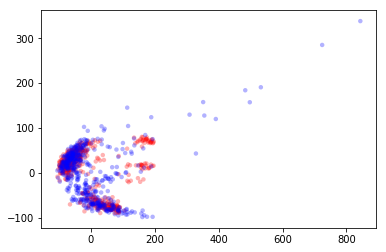

30000 81.55455327033997


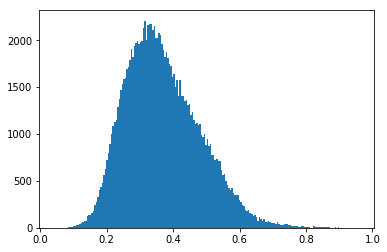

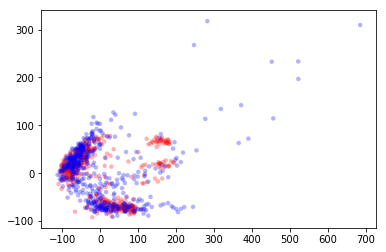

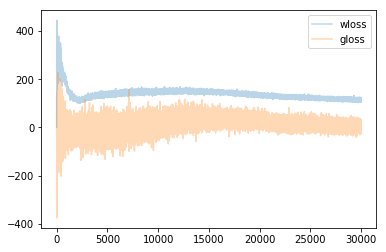

In [4]:
prog.start()
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        samples_true_numpy = sampler.sample_x(batchsize)
        samples_true = Variable(cuda(torch.from_numpy(samples_true_numpy)))
        z = sampler.sample_z(batchsize,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = gen_net(z).detach()
        samples_fake_numpy = cpu(samples_fake.data).numpy()      

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(cuda(torch.from_numpy(
            samples_mid_numpy)),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,cuda(torch.ones(f_mid.size())),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(cpu(loss_critic.data).numpy()[0])

        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()

    prog.add_loss_dis()
    z = sampler.sample_z(batchsize,config['dim_z'])
    z = Variable(cuda(torch.from_numpy(z)))
    samples_fake = gen_net(z)
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(cpu(loss_gen.data).numpy()[0])

    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()

    if (i+1)%config['num_plot'] == 0:
        print(i+1,prog.duration())
        z = sampler.sample_z(500,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = cpu(gen_net(z).data).numpy()
        plot.plot_corr(samples_fake, filename='{}_corr'.format(i+1),show=True)
        plot.plot_scatter(sampler.mat[:,:500].T,samples_fake[:500,:],
            filename='{}_scatter'.format(i+1),show=True)
        prog.start()
prog.plot()


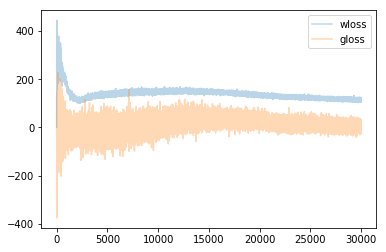

DisNet(
  (fc1): Linear(in_features=6605, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=1, bias=True)
)

In [5]:
prog.plot()
dis_net